# Homework 5 - The eternal significance of publications and citations!

## Import libraries

In [1]:
import pandas as pd
import csv
import json
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import ast
from collections import defaultdict
from tabulate import tabulate
import seaborn as sns
import random
import itertools

In [27]:
pip install tabulate

Note: you may need to restart the kernel to use updated packages.


## [1] Data

In [2]:
file_path = "data.json"

### Data pre-processing
The dataset is quite large and may not fit in your memory when you try constructing your graph. So, what is the solution? You should focus your investigation on a subgraph. You can work on the most connected component in the graph. However, you must first construct and analyze the connections to identify the connected components.

#### 1) Identify the top 10,000 papers with the highest number of citations.

To identify the top 10,000 papers with the highest number of citations, firstly we read the data.json file line by line trying to interpret each line as JSON. If it's successful, we extracts the "id" and "n_citation" fields and adds them to the papers list.

In [3]:
# List to store paper information
papers = []
# Open the file
with open(file_path, "r") as file:
    # Iterate through each line in the file
    for line_number, line in enumerate(file):
        try:
            # Remove any remaining commas, square brackets, or braces
            line = line.strip(',\n')

            try:
                # Load the JSON object from the line
                paper_data = json.loads(line)

                # Extract the relevant information
                paper_id = paper_data["id"]
                # Set number of citations to 0 if it doesn't exist
                paper_citations = paper_data.get("n_citation", 0)

                # Append the information to the 'papers' list
                papers.append({"id": paper_id, "n_citations": paper_citations})

            except json.JSONDecodeError:
                # Print error message for JSON decoding issue and continue to the next line
                print(f"Error in line {line_number}: {line}")
                continue

        except Exception as e:
            # Print generic error message then continue to the next line
            print(f"Generic error in line {line_number}: {line}")
            continue

Error in line 0: [
Error in line 4894082: ]


So now we have a _papers_ list that holds dictionaries where each dictionary contains information about a paper, including its ID and the number of citations it has received. Let's visualize part of it!

In [4]:
print(papers[:5])

[{'id': 1091, 'n_citations': 1}, {'id': 1388, 'n_citations': 1}, {'id': 1674, 'n_citations': 1}, {'id': 1688, 'n_citations': 6}, {'id': 5411, 'n_citations': 0}]


Now we are going to sort the papers based on the number of citations they have (in descending order), select the top 10,000 papers with the highest citations and creates a separate list containing only their IDs.

In [5]:
# Sort the list based on the number of citations
papers.sort(key=lambda paper: paper["n_citations"], reverse=True)
# Extract the top 10000
top_10000_papers = papers[:10000]
# Insert id values in a list
papers_id=[paper["id"] for paper in top_10000_papers]
print(f"We extracted {len(papers_id)} ids.")
has_duplicates = len(papers_id) != len(set(papers_id))
if has_duplicates:
    print("The list papers_id contains duplicates.")
else:
    print("The list papers_id does not contain duplicates.")
print(f"So now we have a list of ids, let's visualize a small part of it: {papers_id[:5]}.")

We extracted 10000 ids.
The list papers_id does not contain duplicates.
So now we have a list of ids, let's visualize a small part of it: [2041404167, 1639032689, 2912565176, 2151103935, 2911964244].


At this point, we are going to re-read each line from the file and appending it to a new DataFrame only if its ID is among the top 10,000 papers' IDs. At the end we should have a dataframe with 10,000 rows, which will be the dataframe we'll be working on.

In [9]:
# Initialize an empty DataFrame for the top 10,000 papers
top_10000_papers_df = pd.DataFrame()

# Open the JSON file
with open(file_path, "r") as file:
    for line in file:
        try:
            # Remove any remaining commas, square brackets, or braces
            line = line.strip(',\n')

            # Load the line as a JSON object
            paper_data = json.loads(line)

            # Check if the paper's ID is in the list of IDs of the top 10,000 papers
            if "id" in paper_data and paper_data["id"] in papers_id:
                # Load the JSON into a temporary DataFrame and append to the main DataFrame
                tmp_df = pd.read_json(line, lines=True)
                top_10000_papers_df = pd.concat([top_10000_papers_df, tmp_df], ignore_index=True)

        except json.JSONDecodeError as e:
            print(f"Error in line: {line}. Error: {e}")
            continue
        except Exception as e:
            print(f"Error in line: {line}. Error: {e}")
            continue

Error in line: [. Error: Expecting value: line 1 column 2 (char 1)
Error in line: ]. Error: Expecting value: line 1 column 1 (char 0)


Let's verify that the new DataFrame has 10,000 rows!

In [10]:
num_rows = len(top_10000_papers_df)
print("The total number of rows in the DataFrame is:", num_rows)

The total number of rows in the DataFrame is: 10000


We'll now save this DataFrame into a JSON file to avoid rerunning the previous code (which takes some time)

In [12]:
# Save results in CSV file
top_10000_papers_df.to_csv("top_10000_papers_csv.csv", index=False)

In [14]:
# Save results in a JSON file
top_10000_papers_df.to_json("top_10000_papers_json.json", orient="records")

Let's read this JSON file , load it into a Pandas DataFrame and analize it !

In [3]:
# Read the JSON file into a DataFrame
top_10000_papers_df = pd.read_json("top_10000_papers_json.json")

# Display the number of rows and columns
num_rows, num_columns = top_10000_papers_df.shape
print(f"Number of rows in the DataFrame: {num_rows}")
print(f"Number of columns in the DataFrame: {num_columns}")

# Display columns in the DataFrame
print("Column Name and Data Type:")
print(top_10000_papers_df.dtypes)

# Count the number of null values per column
null_counts = top_10000_papers_df.isnull().sum()
print("\nNull value counts per column:")
print(null_counts)

# Count the total number of null values in the DataFrame
total_null_values = top_10000_papers_df.isnull().sum().sum()
print(f"\nTotal number of null values in the DataFrame: {total_null_values}")

Number of rows in the DataFrame: 10000
Number of columns in the DataFrame: 17
Column Name and Data Type:
id                   int64
authors             object
title               object
year                 int64
n_citation           int64
page_start          object
page_end            object
doc_type            object
publisher           object
volume              object
issue               object
doi                 object
fos                 object
venue               object
references          object
indexed_abstract    object
alias_ids           object
dtype: object

Null value counts per column:
id                     0
authors                0
title                  0
year                   0
n_citation             0
page_start             0
page_end               0
doc_type               0
publisher              0
volume                 0
issue                  0
doi                    0
fos                    1
venue                399
references          1204
indexed_abstract

#### 2) Based on the available data, you will create two graphs:

##### - Citation graph:
This graph should represent the paper's citation relationships. We want this graph to be **unweighted** and **directed**. The citation should represent the citation given from one paper to another. For example, if paper A has cited paper B, we should expect an edge from node A to B.

- **Nodes:** You can consider each of the papers as your nodes.
- **Edges:** Only consider the citation relationship between these 10,000 papers and ignore the rest.


In this case, we'll only need the 'id' and 'references' columns from the new DataFrame, so let's select just those columns and work with them for simplicity.

In [4]:
# Select only 'id' e 'references' columns
selected_columns = top_10000_papers_df[['id', 'references']]
print(selected_columns.head())

        id                                         references
0   852874                                               None
1  1699105  [17553438, 29630963, 149636774, 1488905225, 15...
2  2169610                                               None
3  4214443  [1965321492, 2082372845, 2103944702, 210478924...
4  4508078                                               None


We create our graph considering that we have to consider each of the papers as our nodes so it means that we will have 10000 different nodes and that we have to to consider only the citation relationships between these 10,000 papers and ignore the rest.

In [5]:
# Create an empty directed graph for citations
citation_graph = nx.DiGraph()

# Get all unique paper IDs from the dataset
unique_ids = selected_columns["id"].unique()

# Add all paper IDs as nodes to the graph
citation_graph.add_nodes_from(unique_ids)

# Add edges only for references present in the dataset
for _, row in selected_columns.iterrows():
    paper_id = row["id"]
    references = row["references"]

    # Check if references is not None before iterating
    if references is not None:
        for ref_id in references:
            if ref_id in unique_ids:
                citation_graph.add_edge(paper_id, ref_id)

Let's verify that we have 10000 nodes

In [6]:
# Print the number of nodes in the graph
print("The number of nodes of the Citation Graph is:", len(citation_graph.nodes))
# Print the number of edges in the graph
print("The number of edges of the Citation Graph is:", len(citation_graph.edges))

The number of nodes of the Citation Graph is: 10000
The number of edges of the Citation Graph is: 52253


The graph is very big so we decided to plot the **strongly connected components**. The strongly connected components in a directed graph are subsets of nodes where every node within the subset can be reached from every other node using directed edges within that subset.

In [7]:
# Find the strongly connected components
scc = list(nx.strongly_connected_components(citation_graph))
# Find the largest component
largest_scc = max(scc, key=len)
# Extract the subgraph related to the largest component
citation_subgraph = citation_graph.subgraph(largest_scc)

# Print the number of nodes 
print("The number of nodes of the Citation SubGraph is:", len(citation_subgraph.nodes))
# Print the number of edges
print("The number of edges of the Citation SubGraph is:", len(citation_subgraph.edges))


The number of nodes of the Citation SubGraph is: 56
The number of edges of the Citation SubGraph is: 238


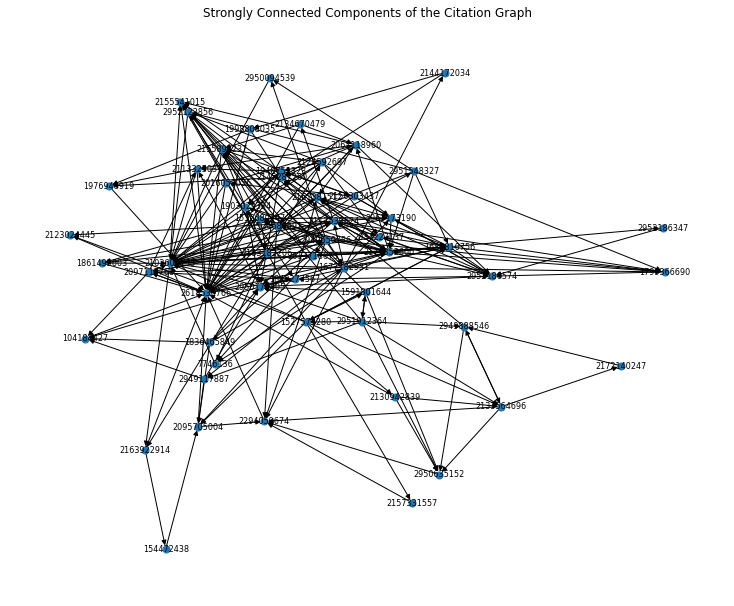

In [8]:
plt.figure(figsize=(10, 8))
pos = nx.spring_layout(citation_subgraph)
nx.draw(citation_subgraph, pos, with_labels=True, node_size=50, font_size=8)
plt.title('Strongly Connected Components of the Citation Graph')
plt.show()

##### - Collaboration graph:
This graph should represent the collaborations of the paper's authors. This graph should be **weighted** and **undirected**. Consider an appropriate weighting scheme for your edges to make your graph weighted.

- **Nodes:** The authors of these papers would be your nodes

- **Edges:** Only consider the collaborations between the authors of these 10,000 papers and ignore the rest.


In [205]:
# Read the top 10,000 papers from the JSON file
top_papers = pd.read_json('top_10000_papers_json.json')

# Create an empty undirected graph for the collaborations
collaboration_graph = nx.Graph()

# Initialize a dictionary to store the count of collaborations between each pair of authors
collaboration_count = defaultdict(lambda: {'count': 0, 'titles': []})

# Iterate over the rows in the dataframe
for _, row in top_papers.iterrows():
    # Get the author dictionaries for the current paper
    author_dicts = row["authors"]

    # Extract titles
    paper_title = row["title"]

    # Iterate over each author dictionary
    for author_dict in author_dicts:
        # Extract the author ID
        author_id = author_dict['id']

        # Iterate over the rest of the author dictionaries
        for other_author_dict in author_dicts:
            # Extract the other author ID
            other_author_id = other_author_dict['id']

            # If the author is not the same as the other author
            if author_id != other_author_id:
                # Increment the count of collaborations between these two authors
                collaboration_count[(author_id, other_author_id)]['count'] += 1
                # Add the title to the titles list for this collaboration
                collaboration_count[(author_id, other_author_id)]['titles'].append(paper_title)

# Add nodes to the graph for each author
for key in collaboration_count.keys():
    # Each key is a tuple of two author IDs
    for author_id in key:
        # Add the author as a node in the graph
        collaboration_graph.add_node(author_id)

# Add edges to the graph for each collaboration, with the weight equal to the count of collaborations
for (author_id1, author_id2), data in collaboration_count.items():
    # Extract collaboration count and titles
    count = data['count']
    titles = data['titles']
    edge_title = titles[-1] if titles else None
    
    # Add an edge between the authors in the graph, with the weight equal to the count of collaborations
    collaboration_graph.add_edge(author_id1, author_id2, weight=count, titles=edge_title)


Let's see how many nodes and edges has our Collaboration Graph:

In [11]:
# Print the number of nodes 
print("The number of nodes of the Collaboration SubGraph is:", len(collaboration_graph.nodes))
# Print the number of edges
print("The number of edges of the Collaboration SubGraph is:", len(collaboration_graph.edges))

The number of nodes of the Collaboration SubGraph is: 20202
The number of edges of the Collaboration SubGraph is: 136476


Given the high number of nodes in the graph, we won't represent it graphically

## 2] Controlling system

### 2.1) Backend Implementation

#### Functionality 1 - Graph's features

In [12]:
def functionality1(graph, graph_name):
    # Number of nodes
    num_nodes = graph.number_of_nodes()

    # Number of edges
    num_edges = graph.number_of_edges()

    # Graph density
    density = nx.density(graph)

    # Degree distribution
    degree_sequence = sorted([d for n, d in graph.degree()], reverse=True)
    
    # Average degree
    avg_degree = np.mean(degree_sequence)

    # 95th percentile of the degree distribution
    percentile_95 = np.percentile(degree_sequence, 95)

    # Graph hubs
    hubs = [node for node, degree in graph.degree() if degree > percentile_95]

    # Whether the graph is dense or sparse
    if density > 0.5:
        density_status = "dense"
    else:
        density_status = "sparse"

    # Output
    output = {
        "Graph Name": graph_name,
        "Number of Nodes": num_nodes,
        "Number of Edges": num_edges,
        "Graph Density": density,
        "Degree Distribution": degree_sequence,
        "Average Degree": avg_degree,
        "Graph Hubs": hubs,
        "Graph Density Status": density_status
    }

    return output

#### Functionality 2 - Nodes' contribution

In [13]:
def functionality2(graph, node, graph_name):
    # Calculate centrality measurements
    betweenness_centrality = nx.betweenness_centrality(graph)[node]
    pagerank_centrality = nx.pagerank(graph)[node]
    closeness_centrality = nx.closeness_centrality(graph)[node]
    degree_centrality = nx.degree_centrality(graph)[node]

    # Output
    output = {
        "Graph Name": graph_name,
        "Node": node,
        "Betweenness Centrality": betweenness_centrality,
        "PageRank Centrality": pagerank_centrality,
        "Closeness Centrality": closeness_centrality,
        "Degree Centrality": degree_centrality
    }

    return output

#### Functionality 3 - Shortest ordered walk

In [215]:
def remove_consecutive_duplicates(lst):
    """
    Removes consecutive duplicates from a list.
    """
    if len(lst) < 2:
        return lst

    result = [lst[0]]

    for i in range(1, len(lst)):
        if lst[i] != lst[i - 1]:
            result.append(lst[i])

    return result

def get_papers_between_nodes(graph, node1, node2):
    """
    Returns the titles of papers between two nodes in the graph.
    """
    papers = []
    try:
        papers = graph[node1][node2]['titles']
    except KeyError:
        print(f"No titles found between nodes {node1} and {node2}")
    return papers

def get_path_between_nodes(graph, node1, node2):
    """
    Returns the shortest path between two nodes in the graph.
    """
    try:
        shortest_path = nx.shortest_path(graph, node1, node2)
    except nx.NetworkXNoPath:
        print(f"No path found between nodes {node1} and {node2}")
        shortest_path = []
    return shortest_path

def shortest_ordered_walk(graph_data, initial_node, end_node, N):
    """
    Finds the shortest ordered walk between initial and end nodes, crossing N random authors.
    """
    if graph_data is not collaboration_graph:
        return 'No walk calculated, you should insert the Collaboration graph'

    degrees = dict(graph_data.degree())
    top_N = sorted(degrees.items(), key=lambda x: x[1], reverse=True)[:N]
    subgraph_auth = graph_data.subgraph([author for author, _ in top_N])
    nodes = list(subgraph_auth.nodes())
    initial_node = nodes[0]
    end_node = nodes[1]

    excluded_authors = [author for author in nodes if author not in [initial_node, end_node]]
    num_random_authors = random.randint(1, min(N - 2, len(excluded_authors)))
    random_authors = random.sample(excluded_authors, num_random_authors)
    
    print("Authors Nodes: ", nodes)
    print("Initial Node: ", initial_node)
    print("End Node: ", end_node)
    print("Authors to cross:", random_authors)

    if not nx.is_connected(subgraph_auth):
        return 'No walk calculated, the subgraph is not connected'

    permutations = list(itertools.permutations(random_authors))

    for i in range(len(permutations)):
        permutations[i] = permutations[i] + (end_node,)

    shortest_walk = []
    cross_papers = []
    min_length = float('inf')

    for permutation in permutations:
        temp_walk = [initial_node] + list(permutation)
        path = []
        papers = []

        for i in range(len(temp_walk) - 1):
            current_node = temp_walk[i]
            next_node = temp_walk[i + 1]

            papers_between_nodes = get_papers_between_nodes(subgraph_auth, current_node, next_node)
            papers += papers_between_nodes

            path_between_nodes = get_path_between_nodes(subgraph_auth, current_node, next_node)
            path += path_between_nodes

        if len(path) < min_length:
            min_length = len(path)
            shortest_walk = path
            cross_papers = papers
    
    cross_papers_out = remove_consecutive_duplicates(cross_papers)
    shortest_walk_out = remove_consecutive_duplicates(shortest_walk)

    return subgraph_auth, shortest_walk_out, cross_papers_out

#### Functionality 4 - Disconnecting Graphs

#### Functionality 5 - Disconnecting Graphs

### 2.2. Frontend Implementation

#### Visualization 1 - Visualize graph features

**1. A table containing the following general information about the graph:**

- **Number of nodes in the graph**
- **Number of edges in the graph**
- **Density of the graph**
- **Average degree of the graph**
- **Whether the network is sparse or dense**


Citation Graph:

In [15]:
# Get data for the table using the functionality1 function
output_data = functionality1(citation_graph, graph_name='citation_graph')

# Organize data for the table
table_data = [
    ["Name of Graph", output_data["Graph Name"]],
    ["Number of nodes in the Graph", output_data["Number of Nodes"]],
    ["Number of edges in the Graph", output_data["Number of Edges"]],
    ["Density of the Graph", output_data["Graph Density"]],
    ["Average degree of the Graph", output_data["Average Degree"]],
    ["The Graph is", output_data["Graph Density Status"]]
]

# Print the table using tabulate
print(tabulate(table_data, headers=["Attribute", "Value"], tablefmt="grid"))


+------------------------------+-----------------------+
| Attribute                    | Value                 |
+==============================+=======================+
| Name of Graph                | citation_graph        |
+------------------------------+-----------------------+
| Number of nodes in the Graph | 10000                 |
+------------------------------+-----------------------+
| Number of edges in the Graph | 52253                 |
+------------------------------+-----------------------+
| Density of the Graph         | 0.0005225822582258226 |
+------------------------------+-----------------------+
| Average degree of the Graph  | 10.4506               |
+------------------------------+-----------------------+
| The Graph is                 | sparse                |
+------------------------------+-----------------------+


Collaboration Graph:

In [16]:
# Get data for the table using the functionality1 function
output_data = functionality1(collaboration_graph, graph_name='collaboration_graph')

# Organize data for the table
table_data = [
    ["Name of Graph", output_data["Graph Name"]],
    ["Number of nodes in the Graph", output_data["Number of Nodes"]],
    ["Number of edges in the Graph", output_data["Number of Edges"]],
    ["Density of the Graph", output_data["Graph Density"]],
    ["Average degree of the Graph", output_data["Average Degree"]],
    ["The Graph is", output_data["Graph Density Status"]]
]

# Print the table using tabulate
print(tabulate(table_data, headers=["Attribute", "Value"], tablefmt="grid"))

+------------------------------+----------------------+
| Attribute                    | Value                |
+==============================+======================+
| Name of Graph                | collaboration_graph  |
+------------------------------+----------------------+
| Number of nodes in the Graph | 20202                |
+------------------------------+----------------------+
| Number of edges in the Graph | 136476               |
+------------------------------+----------------------+
| Density of the Graph         | 0.000668835082972997 |
+------------------------------+----------------------+
| Average degree of the Graph  | 13.51113751113751    |
+------------------------------+----------------------+
| The Graph is                 | sparse               |
+------------------------------+----------------------+


**2. A table that lists the graph's hubs**

Citation Graph:

In [17]:
# Execute functionality1 function to get graph and hub data
output_data = functionality1(citation_graph, graph_name='citation_graph')

# Extract relevant data from the output
graph_name = output_data["Graph Name"]
hubs = output_data["Graph Hubs"]

# Consider only the first 10 hubs
first_10_hubs = hubs[:10]

# Convert node numbers into a list of lists for tabulate, directly converting nodes to strings
hub_table = [[index, str(node)] for index, node in enumerate(first_10_hubs, start=1)]

# Create a table using tabulate
table = tabulate(hub_table, headers=["Index", "Node"], tablefmt="grid")

# Print the table
print(table)

+---------+------------+
|   Index |       Node |
+=========+============+
|       1 | 1480415088 |
+---------+------------+
|       2 | 1481420047 |
+---------+------------+
|       3 | 1499049447 |
+---------+------------+
|       4 | 1480376833 |
+---------+------------+
|       5 | 1502916507 |
+---------+------------+
|       6 | 1506285740 |
+---------+------------+
|       7 | 1515402129 |
+---------+------------+
|       8 | 1520914943 |
+---------+------------+
|       9 | 1535271175 |
+---------+------------+
|      10 | 1536680647 |
+---------+------------+


Collaboration Graph:

In [18]:
# Execute functionality1 function to get graph and hub data
output_data = functionality1(collaboration_graph, graph_name='colaboration_graph')

# Extract relevant data from the output
graph_name = output_data["Graph Name"]
hubs = output_data["Graph Hubs"]

# Consider only the first 10 hubs
first_10_hubs = hubs[:10]

# Convert node numbers into a list of lists for tabulate, directly converting nodes to strings
hub_table = [[index, str(node)] for index, node in enumerate(first_10_hubs, start=1)]

# Create a table using tabulate
table = tabulate(hub_table, headers=["Index", "Node"], tablefmt="grid")

# Print the table
print(table)

+---------+------------+
|   Index |       Node |
+=========+============+
|       1 |  295353625 |
+---------+------------+
|       2 |  161269817 |
+---------+------------+
|       3 | 2104401652 |
+---------+------------+
|       4 | 2075956027 |
+---------+------------+
|       5 |  215131072 |
+---------+------------+
|       6 | 1111049960 |
+---------+------------+
|       7 | 2004792601 |
+---------+------------+
|       8 | 2485834696 |
+---------+------------+
|       9 | 2462121670 |
+---------+------------+
|      10 | 2328522601 |
+---------+------------+


**3. A plot depicting the distribution of the citations received by papers (Citation graph)**

**Note** : For the points 3 and 4 we choosed to analyze the strongly connected component (previously defined). Focusing on the strongly connected component helps analyze citations among closely linked papers, offering a clearer picture of meaningful interactions and reducing noise from less relevant citations

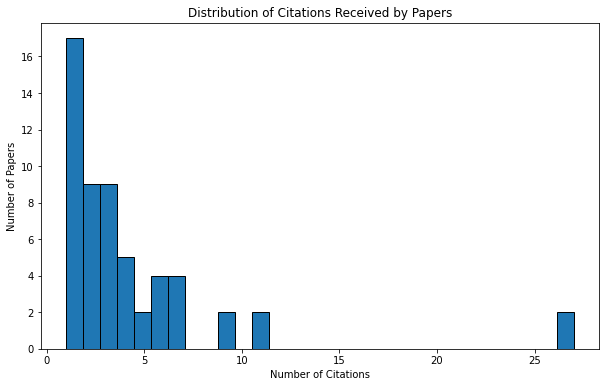

In [19]:
# Calculate the number of citations received by each paper in the citation graph
citation_counts = [d for n, d in citation_subgraph.in_degree()]

# Create the plot
plt.figure(figsize=(10, 6))
plt.hist(citation_counts, bins=30, edgecolor='black')  # Crea l'istogramma usando Matplotlib
plt.title('Distribution of Citations Received by Papers')
plt.xlabel('Number of Citations')
plt.ylabel('Number of Papers')
plt.show()

**4. A plot depicting the distribution of the given citations by papers (Citation graph)**

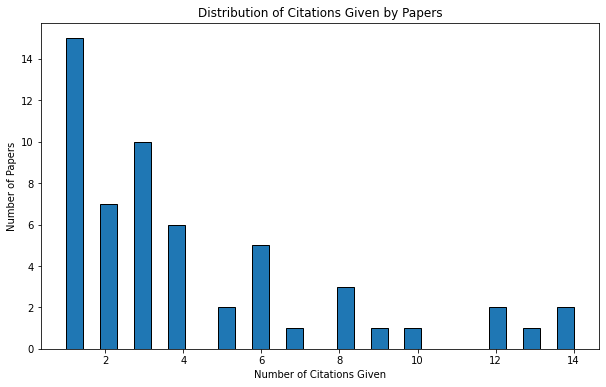

In [20]:
# Calculate the number of citations given by each paper in the citation graph
citations_given = [d for n, d in citation_subgraph.out_degree()]

# Create the histogram depicting the distribution of citations given
plt.figure(figsize=(10, 6))
plt.hist(citations_given, bins=30, edgecolor='black')  
plt.title('Distribution of Citations Given by Papers')
plt.xlabel('Number of Citations Given')
plt.ylabel('Number of Papers')
plt.show()

**5. A plot depicting the number of collaborations of the author (Collaboration graph)**

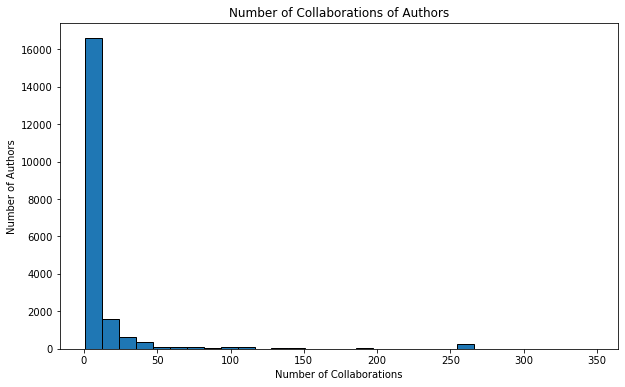

In [21]:
# Calculate the number of collaborations for each author
collaborations = collaboration_graph.degree()

# Extract the degrees (number of collaborations) for each author
degrees = [degree for author, degree in collaborations]

# Plotting
plt.figure(figsize=(10, 6))
plt.hist(degrees, bins=30, edgecolor='black')  
plt.title('Number of Collaborations of Authors')
plt.xlabel('Number of Collaborations')
plt.ylabel('Number of Authors')
plt.show()


#### Visualization 2 - Visualize the node's contribution

**1. A table containing the node's centrality value based on the four centrality measurements**


Citation Graph:

In [74]:
# Extract a random node from the graph
random_node = random.choice(list(citation_graph.nodes()))

# Call functionality2 to get centrality measurements for that specific node
result = functionality2(citation_graph, random_node, graph_name='citation_graph')

# Extract centrality values and convert to strings
node = str(result['Node'])
betweenness = str(result['Betweenness Centrality'])
pagerank = str(result['PageRank Centrality'])
closeness = str(result['Closeness Centrality'])
degree_centrality = str(result['Degree Centrality'])

# Create a table of centrality values
centrality_table = [
    ['Node', 'Betweenness Centrality', 'PageRank Centrality', 'Closeness Centrality', 'Degree Centrality'],
    [node, betweenness, pagerank, closeness, degree_centrality]
]

# Display the table
print(tabulate(centrality_table, headers='firstrow'))

      Node    Betweenness Centrality    PageRank Centrality    Closeness Centrality    Degree Centrality
----------  ------------------------  ---------------------  ----------------------  -------------------
2153950497                         0            3.67648e-05                       0           0.00070007


Collaboration Graph:

In [76]:
# Extract a random node from the graph
random_node = random.choice(list(collaboration_graph.nodes()))

# Call functionality2 to get centrality measurements for that specific node
result = functionality2(collaboration_graph, random_node, graph_name='collaboration_graph')

# Extract centrality values and convert to strings
node = str(result['Node'])
betweenness = str(result['Betweenness Centrality'])
pagerank = str(result['PageRank Centrality'])
closeness = str(result['Closeness Centrality'])
degree_centrality = str(result['Degree Centrality'])

# Create a table of centrality values
centrality_table = [
    ['Node', 'Betweenness Centrality', 'PageRank Centrality', 'Closeness Centrality', 'Degree Centrality'],
    [node, betweenness, pagerank, closeness, degree_centrality]
]

# Display the table
print(tabulate(centrality_table, headers='firstrow'))

      Node    Betweenness Centrality    PageRank Centrality    Closeness Centrality    Degree Centrality
----------  ------------------------  ---------------------  ----------------------  -------------------
2153823796                         0            5.68812e-05             0.000419315          0.000346517


#### Visualization 3 - Visualize the shortest-ordered route

Authors Nodes:  [332422508, 1973035492, 2146468246, 173839695]
Initial Node:  332422508
End Node:  1973035492
Authors to cross: [173839695, 2146468246]


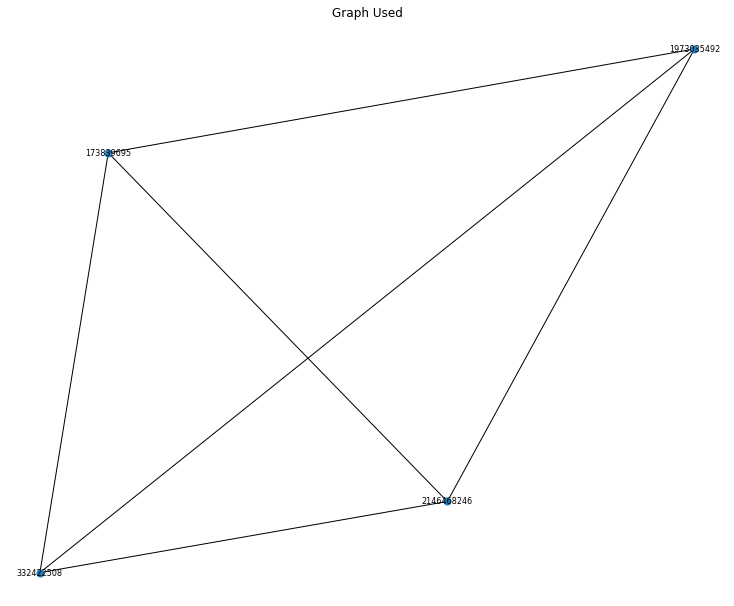

In [208]:
authors_list = []
initial_node = 0
end_node = 0
N = 4

result = shortest_ordered_walk(collaboration_graph, initial_node, end_node, N)
graph_used=result[0]
path = result[1]
papers = result[2]

plt.figure(figsize=(10, 8))
pos = nx.spring_layout(graph_used)
nx.draw(graph_used, pos, with_labels=True, node_size=50, font_size=8)
plt.title('Graph Used')
plt.show()

**1. Print the papers needed to be crossed in the shortest walk in order**

In [209]:
def get_papers_for_shortest_walk(G, path):
    # Initialize an empty list to hold the papers (edges) in the walk
    papers_in_walk = []

    # Iterate through the path and find the papers connecting each consecutive pair of authors
    for i in range(len(path) - 1):
        start_author = path[i]
        end_author = path[i + 1]
        
        # Retrieve the papers (or collaborations) associated with the edge
        # This assumes you have an attribute for each edge that lists the associated paper(s)
        # Adjust the attribute name as per your graph's data
        papers = G[start_author][end_author].get('titles', 'Unknown Paper')
        
        # If multiple papers are found, you might want to handle them here
        # For simplicity, we're assuming it's a single identifier
        papers_in_walk.append((start_author, end_author, papers))

    return papers_in_walk

In [210]:
papers_in_walk = get_papers_for_shortest_walk(graph_used, path)
# Print the papers in order
print("Papers needed to be crossed in the shortest walk: \n")
for i, (start, end, paper) in enumerate(papers_in_walk, 1):
    print(f"{i}. Between {start} and {end}: Papers: {paper} +\n")

Papers needed to be crossed in the shortest walk: 

1. Between 332422508 and 173839695: Papers: The Universal Protein Resource (UniProt) in 2010 +

2. Between 173839695 and 2146468246: Papers: UniProt: A hub for protein information +

3. Between 2146468246 and 1973035492: Papers: InterPro in 2017—beyond protein family and domain annotations +



**2. Plot the graph and identify the nodes and edges that appear in the shortest walk (please put an identifier on each edge in the shortest walk to determine the order that we should have the walk)**

In [211]:
print(path)

[332422508, 173839695, 2146468246, 1973035492]


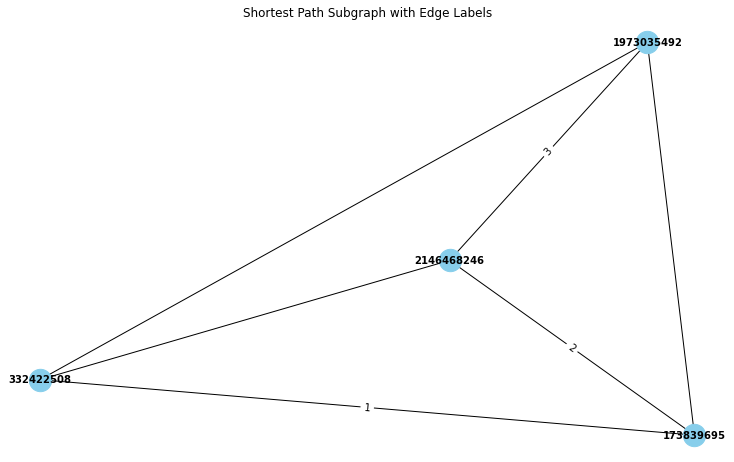

In [212]:
# Create a subgraph with nodes from the shortest path
shortest_path_subgraph = collaboration_graph.subgraph(path)

# Create a dictionary of edge labels based on order in the shortest path
edge_labels = {(path[i], path[i + 1]): str(i + 1) for i in range(len(path) - 1)}

# Draw the subgraph with labels on the edges
plt.figure(figsize=(10, 6))
pos = nx.spring_layout(shortest_path_subgraph)
nx.draw(shortest_path_subgraph, pos=pos, with_labels=True, node_color='skyblue', node_size=500, font_weight='bold', font_size=10)
nx.draw_networkx_edge_labels(shortest_path_subgraph, pos=pos, edge_labels=edge_labels)
plt.title('Shortest Path Subgraph with Edge Labels')
plt.show()

#### Visualization 4 - Visualize the disconnected graph

**1. Print the number of the links that should be disconnected**

**2.Plot the original graph**

**3. Plot the graph after removing the links and identify the two nodes**

#### Visualization 5 - Visualize the communities

**1. Print the number of links that should be removed to have the communities**

**2. A table depicting the communities and the papers that belong to each community**

**3.Plot the original graph**

**4.Plot the graph showing the communities in the network**

**5.Plot the final graph and identify the community/communities of Paper_1 and Paper_2**